In [114]:
# =======================
# ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ Î∞è ÌôòÍ≤Ω ÏÑ§Ï†ï

import warnings

# Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨
import pandas as pd
import numpy as np

# ÏãúÍ∞ÅÌôî
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# Ï†ÑÏ≤òÎ¶¨
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# Î™®Îç∏ÎßÅ
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Îî•Îü¨Îãù (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# =======================
# Í≤ΩÍ≥† Î¨¥Ïãú ÏÑ§Ï†ï (FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (Mac: AppleGothic, Windows: 'Malgun Gothic' ÏÇ¨Ïö©)
rc('font', family='AppleGothic')

# ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ
plt.rcParams['axes.unicode_minus'] = False

In [115]:
train = pd.read_csv('../../data/raw/train.csv')
test = pd.read_csv('../../data/raw/test.csv')

# Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò

In [116]:
def preprocess(df):
    """
    Ï£ºÏñ¥ÏßÑ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóê ÎåÄÌï¥ Ï†ÑÏ≤òÎ¶¨ ÏàòÌñâ:
    - Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
    - Ïù∏ÏΩîÎî©
    - Îß§Ìïë
    - ÌòïÎ≥ÄÌôò Îì±
    """
    # 1. ÏÑ§Î¶ΩÏó∞ÎèÑ: Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö© (Ìå®Ïä§)

    # 2. Íµ≠Í∞Ä: ÏõêÌï´ Ïù∏ÏΩîÎî©
    df = pd.get_dummies(df, columns=['Íµ≠Í∞Ä'])

    # 3. Î∂ÑÏïº: Í≤∞Ï∏°Ïπò ‚Üí 'Unknown', ÏõêÌï´ Ïù∏ÏΩîÎî©
    df['Î∂ÑÏïº'].fillna('Unknown', inplace=True)
    df = pd.get_dummies(df, columns=['Î∂ÑÏïº'])

    # 4. Ìà¨ÏûêÎã®Í≥Ñ: ÏàòÎèô Îß§Ìïë
    investment_stage_order = {
        'Seed': 0,
        'Series A': 1,
        'Series B': 2,
        'Series C': 3,
        'IPO': 4
    }
    df['Ìà¨ÏûêÎã®Í≥Ñ'] = df['Ìà¨ÏûêÎã®Í≥Ñ'].map(investment_stage_order)

    # 5. ÏßÅÏõê Ïàò: ÌèâÍ∑†ÏúºÎ°ú ÎåÄÏ≤¥
    mean_emp = df['ÏßÅÏõê Ïàò'].mean()
    df['ÏßÅÏõê Ïàò'].fillna(mean_emp, inplace=True)

    # 6. Ïù∏ÏàòÏó¨Î∂Ä, ÏÉÅÏû•Ïó¨Î∂Ä: ÏõêÌï´ Ïù∏ÏΩîÎî©
    df = pd.get_dummies(df, columns=['Ïù∏ÏàòÏó¨Î∂Ä', 'ÏÉÅÏû•Ïó¨Î∂Ä'])

    # 7. Í≥†Í∞ùÏàò: Ï§ëÏïôÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
    median_cust = df['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)'].median()
    df['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)'].fillna(median_cust, inplace=True)

    # 8. Ï¥ù Ìà¨ÏûêÍ∏à, Ïó∞Îß§Ï∂ú: Ï†ïÏàòÌòï Î≥ÄÌôò
    df['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'] = df['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'].astype(int)
    df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'].astype(int)

    # 9. SNS ÌåîÎ°úÏõå Ïàò: Í∞íÏù¥ 0Ïù∏ Í≤ΩÏö∞ ÏµúÎπàÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
    mode_sns = df[df['SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)'] != 0]['SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)'].mode()[0]
    df.loc[df['SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)'] == 0, 'SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)'] = mode_sns

    # 10. Í∏∞ÏóÖÍ∞ÄÏπò: Í≤∞Ï∏°Ïπò Î≥¥ÏôÑ + ÏàòÏπò Îß§Ìïë
    df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'].fillna('4500~6000', inplace=True)
    value_map = {
        '1500~2500': 2000,
        '2500~3500': 3000,
        '3500~4500': 4000,
        '4500~6000': 5250,
        '6000Ïù¥ÏÉÅ': 6500
    }
    df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] = df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'].map(value_map)
    df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'].fillna(5250, inplace=True)  # Îß§Ìïë Ïã§Ìå® Î≥¥ÏôÑ

    return df

# ÌååÏÉùÎ≥ÄÏàò ÏÉùÏÑ±

In [117]:
def add_features(df):
    # 1. Í∏∞ÏóÖÎÇòÏù¥
    df['Í∏∞ÏóÖÎÇòÏù¥'] = 2025 - df['ÏÑ§Î¶ΩÏó∞ÎèÑ']

    # 2. ÏßÅÏõêÎãπ Îß§Ï∂ú
    df['ÏßÅÏõêÎãπÎß§Ï∂ú'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / df['ÏßÅÏõê Ïàò'].replace(0, np.nan)

    # 3. Í≥†Í∞ùÎãπ Îß§Ï∂ú
    df['Í≥†Í∞ùÎãπÎß§Ï∂ú'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / df['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)'].replace(0, np.nan)

    # 4. Ìà¨ÏûêÏàòÏùµÎπÑ
    df['Ìà¨ÏûêÏàòÏùµÎπÑ'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / df['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'].replace(0, np.nan)

    # 5. SNS ÌåîÎ°úÏõå Îì±Í∏â
    df['SNSÌåîÎ°úÏõåÎì±Í∏â'] = pd.cut(df['SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)'],
                             bins=[-1, 1, 3, 10],
                             labels=['ÎÇÆÏùå', 'Ï§ëÍ∞Ñ', 'ÎÜíÏùå'])

    # 6. Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú (Í∏∞ÏóÖÍ∞ÄÏπò Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ Ìè¨Ìï®)
    df['Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú'] = df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] / df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'].replace(0, np.nan)

    # 7. Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò
    df['Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò'] = df['ÏßÅÏõê Ïàò'] / df['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'].replace(0, np.nan)

    return df

# Ïä§ÏºÄÏùºÎßÅ (MinMaxSclaer, Log)

In [118]:
def scaleing(df):
    scale_cols = [
        'ÏÑ§Î¶ΩÏó∞ÎèÑ',
        'Ìà¨ÏûêÎã®Í≥Ñ',
        'ÏßÅÏõê Ïàò',
        'Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)',
        'Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)',
        'Ïó∞Îß§Ï∂ú(ÏñµÏõê)',
        'SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)',
        'Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)',
        'Í∏∞ÏóÖÎÇòÏù¥',
        'ÏßÅÏõêÎãπÎß§Ï∂ú',
        'Í≥†Í∞ùÎãπÎß§Ï∂ú',
        'Ìà¨ÏûêÏàòÏùµÎπÑ',
        'Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú',
        'Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò',
        'SNSÌåîÎ°úÏõåÎì±Í∏â',
        #'ÏÑ±Í≥µÌôïÎ•†'
    ]
    # Ïä§ÏºÄÏùºÎßÅ Ï†ÅÏö©
    scaler = MinMaxScaler()
    train[scale_cols] = scaler.fit_transform(train[scale_cols])
    
    # ÌÉÄÍ≤üÎ≥ÄÏàò Î°úÍ∑∏ Ïä§ÏºÄÏùºÎßÅ
    #train['ÏÑ±Í≥µÌôïÎ•†'] = np.log(train['ÏÑ±Í≥µÌôïÎ•†'])
    return df

def scaleing_for_test(df):
    '''
    Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏóêÎäî ÏÑ±Í≥µÌôïÎ•† Ïª¨ÎüºÏù¥ ÏóÜÍ∏∞ ÎïåÎ¨∏Ïóê Î°úÍ∑∏ Î≥ÄÌôò ÏΩîÎìúÎ•º ÏÇ≠Ï†úÌï®
    '''
    scale_cols = [
        'ÏÑ§Î¶ΩÏó∞ÎèÑ',
        'Ìà¨ÏûêÎã®Í≥Ñ',
        'ÏßÅÏõê Ïàò',
        'Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)',
        'Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)',
        'Ïó∞Îß§Ï∂ú(ÏñµÏõê)',
        'SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)',
        'Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)',
        'Í∏∞ÏóÖÎÇòÏù¥',
        'ÏßÅÏõêÎãπÎß§Ï∂ú',
        'Í≥†Í∞ùÎãπÎß§Ï∂ú',
        'Ìà¨ÏûêÏàòÏùµÎπÑ',
        'Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú',
        'Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò',
        'SNSÌåîÎ°úÏõåÎì±Í∏â'
    ]
    # Ïä§ÏºÄÏùºÎßÅ Ï†ÅÏö©
    scaler = MinMaxScaler()
    df[scale_cols] = scaler.fit_transform(df[scale_cols])

    return df

# ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è Ï†ÄÏû•

In [119]:
train = preprocess(train)
train = add_features(train)


test = preprocess(test)
test = add_features(test)

In [120]:
# 1. ÌååÏÉùÎ≥ÄÏàò Î¶¨Ïä§Ìä∏
derived_cols = [
    'Í∏∞ÏóÖÎÇòÏù¥',
    'ÏßÅÏõêÎãπÎß§Ï∂ú',
    'Í≥†Í∞ùÎãπÎß§Ï∂ú',
    'Ìà¨ÏûêÏàòÏùµÎπÑ',
    'SNSÌåîÎ°úÏõåÎì±Í∏â',
    'Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú',
    'Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò'
]


In [121]:
train[derived_cols].describe()

Í∏∞ÏóÖÎÇòÏù¥        ÏßÅÏõêÎãπÎß§Ï∂ú         Í≥†Í∞ùÎãπÎß§Ï∂ú        Ìà¨ÏûêÏàòÏùµÎπÑ       Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú  \
count  4376.000000  4376.000000   4376.000000  4376.000000  4376.000000   
mean     12.993144     8.196005    259.339256     6.576375     2.854454   
std       6.554872    39.929063    681.294346    34.494157    16.781722   
min       2.000000     0.002524      0.213115     0.002337     0.354203   
25%       7.000000     1.285796     65.346939     0.987430     0.555262   
50%      13.000000     2.583085    130.461310     1.971545     0.840533   
75%      19.000000     5.134961    222.081633     3.714307     1.764706   
max      24.000000  1649.285714  11112.000000  1015.000000   437.500000   

          Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò  
count  4376.000000  
mean      2.344582  
std      12.537766  
min       0.001828  
25%       0.387628  
50%       0.753905  
75%       1.467620  
max     382.538462

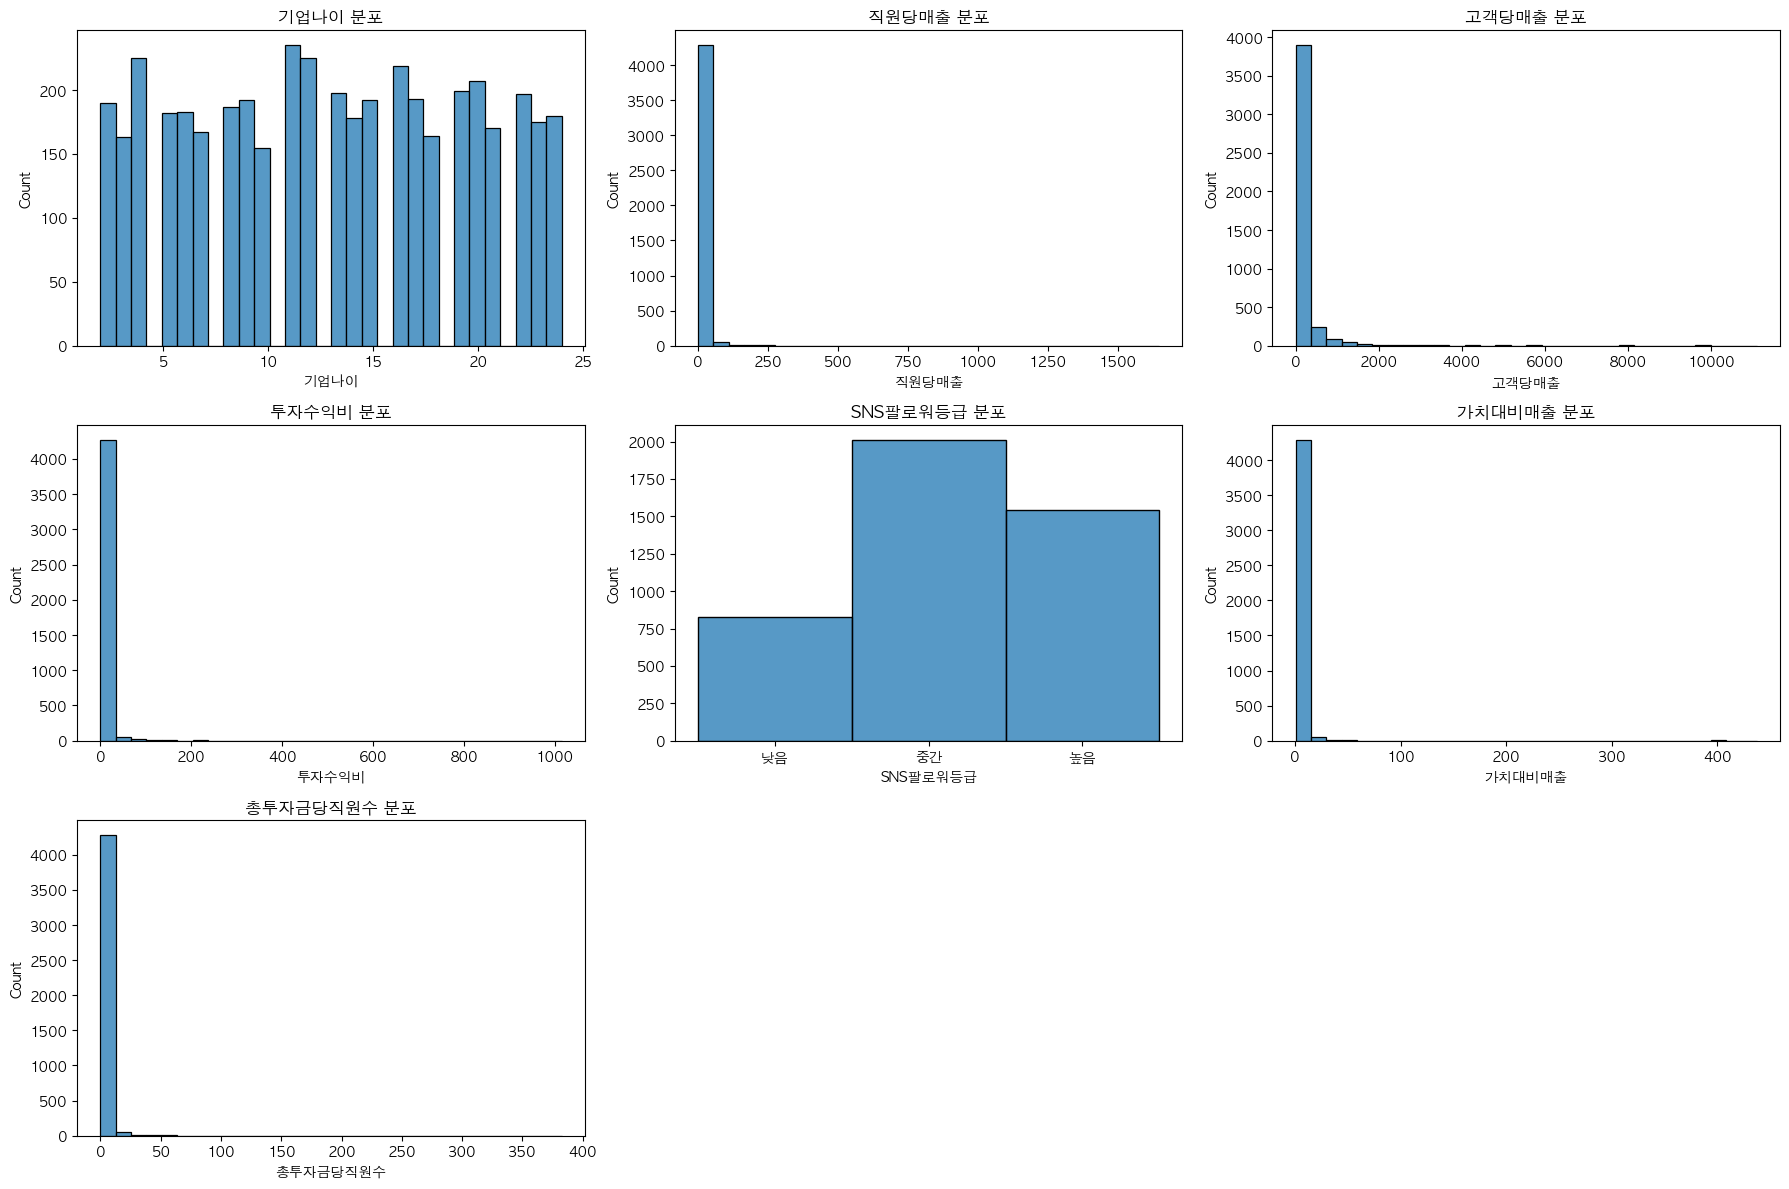

In [122]:

plt.figure(figsize=(18, 12))
for i, col in enumerate(derived_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(train[col].dropna(), kde=False, bins=30)
    plt.title(f'{col} Î∂ÑÌè¨')
plt.tight_layout()
plt.show()

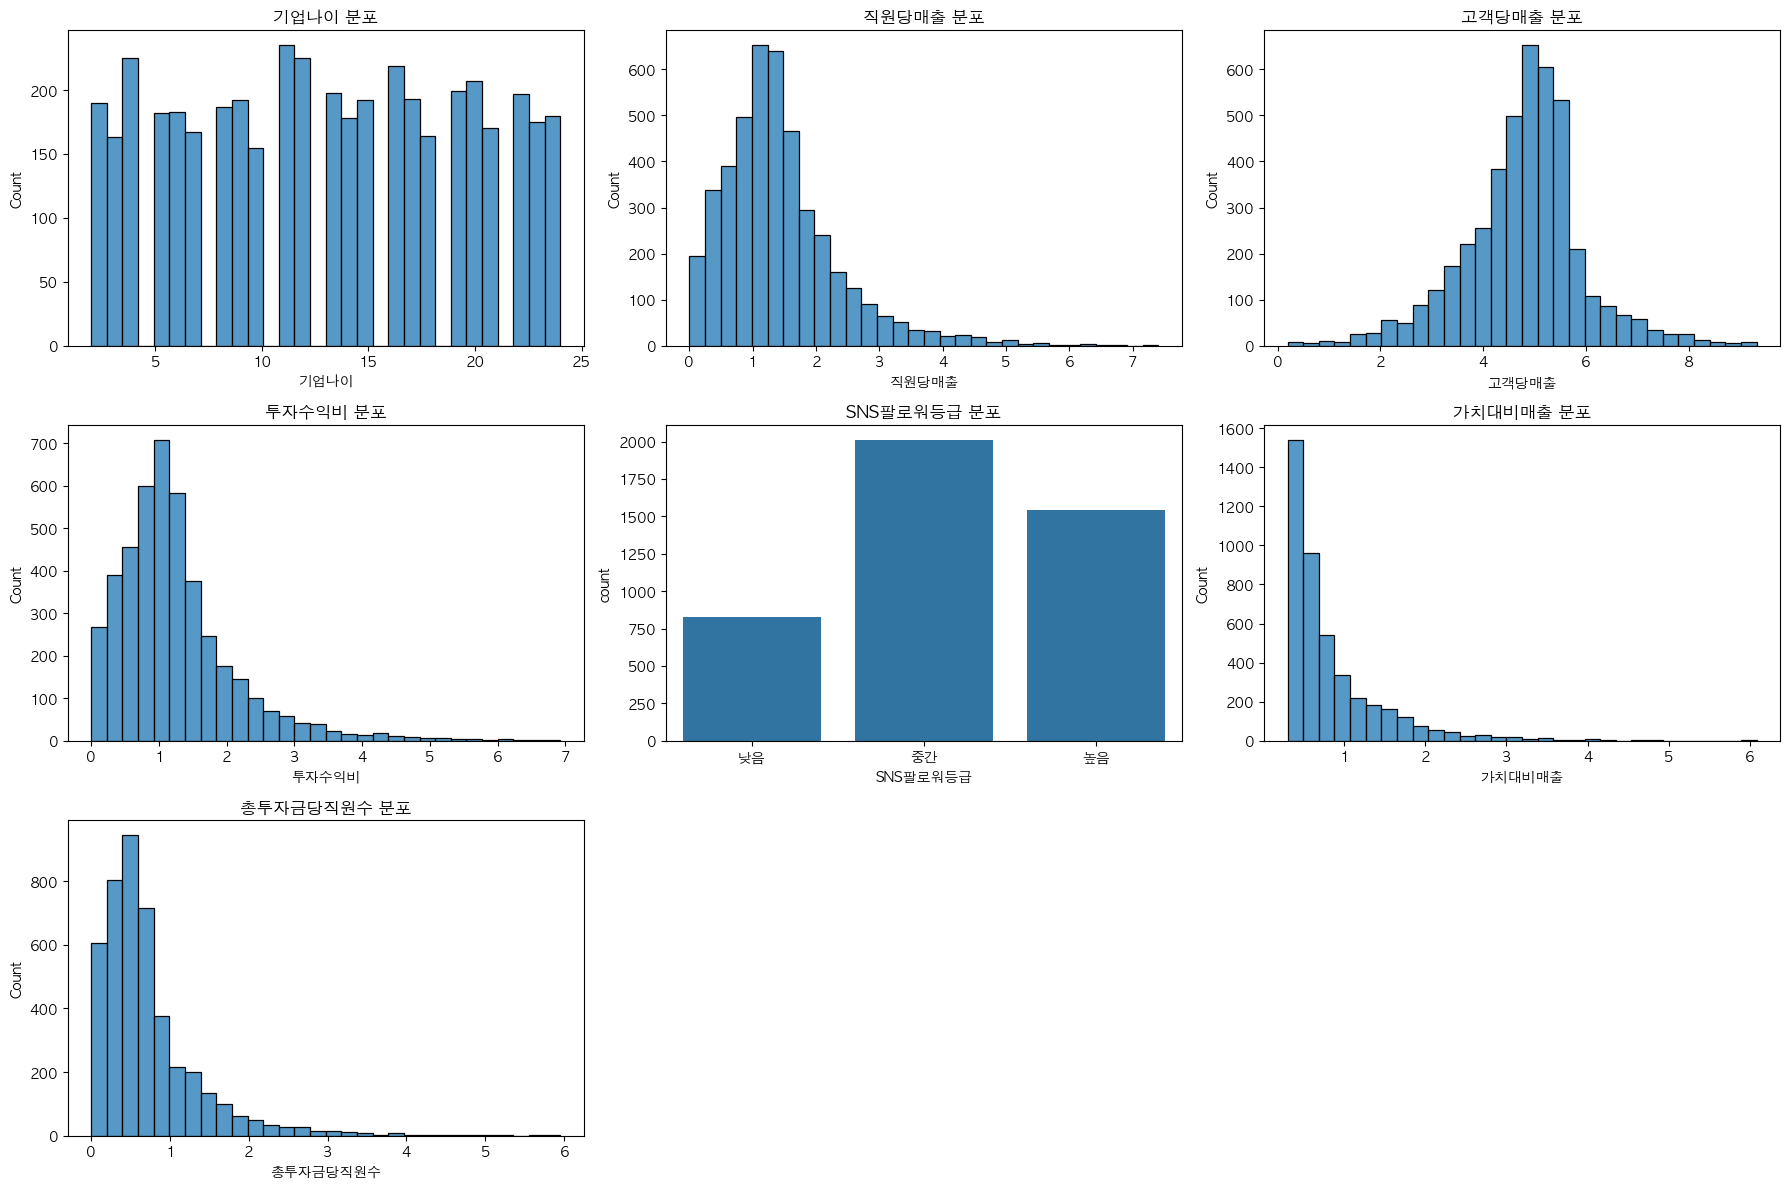

In [123]:

# 2. Î°úÍ∑∏ Î≥ÄÌôò ÎåÄÏÉÅ Î≥ÄÏàò
log_cols = ['ÏßÅÏõêÎãπÎß§Ï∂ú', 'Í≥†Í∞ùÎãπÎß§Ï∂ú', 'Ìà¨ÏûêÏàòÏùµÎπÑ', 'Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú', 'Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò']

# 3. Î°úÍ∑∏ Î≥ÄÌôò Ìï®Ïàò
def log_transform_columns(df, columns):
    df_copy = df.copy()
    for col in columns:
        # 0 Ïù¥Ìïò Í∞í ÏûàÎäî Í≤ΩÏö∞ ÏÉùÎûµ
        if (df_copy[col] > 0).all():
            df_copy[col] = np.log1p(df_copy[col])
        else:
            print(f"{col}: 0 Ïù¥Ìïò Í∞í Ï°¥Ïû¨ ‚Üí Î°úÍ∑∏ Î≥ÄÌôò ÏÉùÎûµ")
    return df_copy

# 4. Î°úÍ∑∏ Î≥ÄÌôò Ï†ÅÏö©
train_log = log_transform_columns(train, log_cols)

# 5. ÌååÏÉùÎ≥ÄÏàò Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî (Î°úÍ∑∏ Î≥ÄÌôò ÌõÑ Í∏∞Ï§Ä)
plt.figure(figsize=(18, 12))
for i, col in enumerate(derived_cols):
    plt.subplot(3, 3, i + 1)
    # SNSÌåîÎ°úÏõåÎì±Í∏âÏùÄ Î≤îÏ£ºÌòïÏù¥ÎØÄÎ°ú ÎßâÎåÄÍ∑∏ÎûòÌîÑÎ°ú ÏãúÍ∞ÅÌôî
    if col == 'SNSÌåîÎ°úÏõåÎì±Í∏â':
        sns.countplot(x=train[col])
    else:
        sns.histplot(train_log[col].dropna(), kde=False, bins=30)
    plt.title(f'{col} Î∂ÑÌè¨')
plt.tight_layout()
plt.show()

# ÌîºÏ≥ê Ï§ëÏöîÎèÑ ÌôïÏù∏

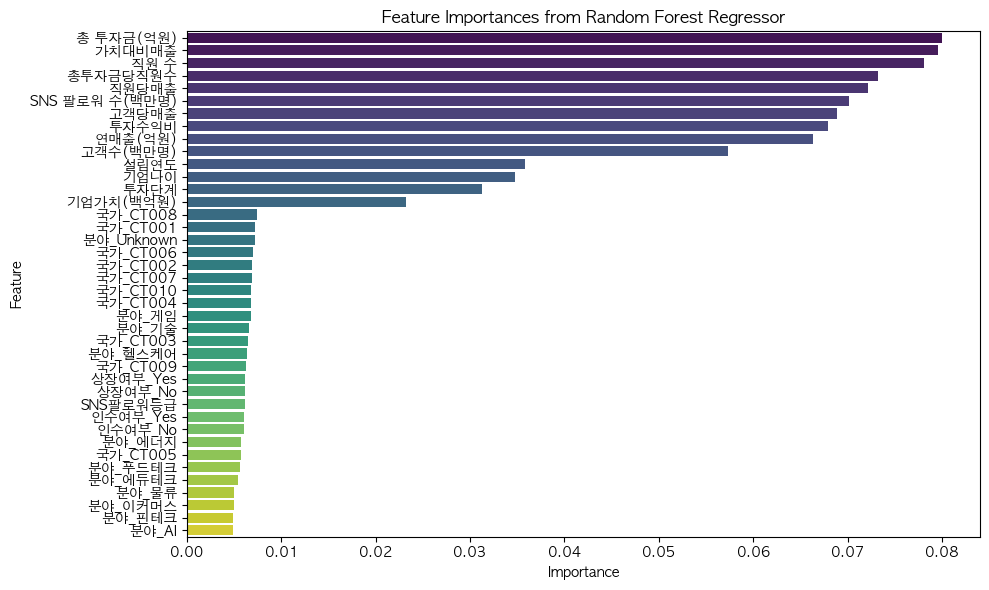

In [124]:

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
train = pd.read_csv('../../data/processed/processed_train.csv')
X = train.drop(columns=['ÏÑ±Í≥µÌôïÎ•†', 'ID'])
y = train['ÏÑ±Í≥µÌôïÎ•†']

# 2. Î™®Îç∏ Ï†ïÏùò Î∞è ÌïôÏäµ
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# 3. ÌîºÏ≤ò Ï§ëÏöîÎèÑ Ï∂îÏ∂ú
feature_importances = model.feature_importances_
feature_names = X.columns

# 4. ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 5. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances from Random Forest Regressor')
plt.tight_layout()
plt.show()

In [125]:
target_cols = ['ID','Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)','Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú','ÏßÅÏõê Ïàò','Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò',
               'ÏßÅÏõêÎãπÎß§Ï∂ú','SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)',
               'Í≥†Í∞ùÎãπÎß§Ï∂ú','Ìà¨ÏûêÏàòÏùµÎπÑ','Ïó∞Îß§Ï∂ú(ÏñµÏõê)','Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)',
               'ÏÑ§Î¶ΩÏó∞ÎèÑ','Í∏∞ÏóÖÎÇòÏù¥','Ìà¨ÏûêÎã®Í≥Ñ','Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)','ÏÑ±Í≥µÌôïÎ•†']

target_cols_for_test = ['ID','Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)','Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú','ÏßÅÏõê Ïàò','Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò',
               'ÏßÅÏõêÎãπÎß§Ï∂ú','SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)',
               'Í≥†Í∞ùÎãπÎß§Ï∂ú','Ìà¨ÏûêÏàòÏùµÎπÑ','Ïó∞Îß§Ï∂ú(ÏñµÏõê)','Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)',
               'ÏÑ§Î¶ΩÏó∞ÎèÑ','Í∏∞ÏóÖÎÇòÏù¥','Ìà¨ÏûêÎã®Í≥Ñ','Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)']



In [126]:
feature_importance_train = train[target_cols]
feature_importance_test = test[target_cols_for_test]

In [127]:
feature_importance_train.to_csv("../../data/processed/feature_importance_train.csv", index=False)
feature_importance_test.to_csv("../../data/processed/feature_importance_test.csv", index=False)


In [128]:
feature_importance_train

ID  Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)    Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú      ÏßÅÏõê Ïàò  Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò     ÏßÅÏõêÎãπÎß§Ï∂ú  \
0     TRAIN_3959   0.073081  0.001694  0.407170  0.010105  0.001406   
1     TRAIN_0733   0.233858  0.006809  0.609053  0.004792  0.000414   
2     TRAIN_3824   0.586491  0.000438  0.493956  0.001554  0.003112   
3     TRAIN_4168   0.168157  0.001011  0.363509  0.003970  0.002390   
4     TRAIN_3771   0.684972  0.001688  0.333267  0.000897  0.000830   
...          ...        ...       ...       ...       ...       ...   
3795  TRAIN_0836   0.594437  0.000445  0.919487  0.002855  0.000799   
3796  TRAIN_2467   0.637151  0.002070  0.047466  0.000136  0.009980   
3797  TRAIN_3181   0.669930  0.001681  0.169037  0.000464  0.005334   
3798  TRAIN_3923   0.313609  0.004469  0.676948  0.003978  0.000556   
3799  TRAIN_0792   0.221229  0.002857  0.097537  0.000814  0.002669   

      SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)     Í≥†Í∞ùÎãπÎß§Ï∂ú     Ìà¨ÏûêÏàòÏùµÎπÑ   Ïó∞Îß§Ï∂ú(ÏñµÏõê)  Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)      ÏÑ§Î¶ΩÏó∞ÎèÑ  \
0              0.908  0.035461  0.008842  0.318636  0.112245  0.909091   
1              0.400  0.002390  0.001237  0.140176  0.785714  0.681818   
2              0.596  0.023184  0.003014  0.855976  0.491983  0.454545   
3              0.854  0.013109  0.005907  0.483930  0.491983  0.954545   
4              0.352  0.004168  0.000464  0.153815  0.491983  0.772727   
...              ...       ...       ...       ...       ...       ...   
3795           0.600  0.018187  0.001421  0.408980  0.295918  0.045455   
3796           0.174  0.004301  0.000870  0.268197  0.836735  1.000000   
3797           0.400  0.010016  0.001553  0.503646  0.673469  0.727273   
3798           0.638  0.005670  0.001377  0.209251  0.491983  0.318182   
3799           0.440  0.003943  0.001357  0.145510  0.491983  0.727273   

          Í∏∞ÏóÖÎÇòÏù¥  Ìà¨ÏûêÎã®Í≥Ñ  Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)  ÏÑ±Í≥µÌôïÎ•†  
0     0.090909  0.75   0.476429   0.1  
1     0.318182  0.75   1.000000   0.1  
2     0.545455  0.00   0.476429   0.1  
3     0.045455  0.25   0.476429   0.1  
4     0.227273  1.00   0.000000   0.1  
...        ...   ...        ...   ...  
3795  0.954545  1.00   0.000000   0.9  
3796  0.000000  0.25   0.476429   0.9  
3797  0.272727  1.00   1.000000   0.9  
3798  0.681818  0.75   1.000000   0.9  
3799  0.272727  0.00   0.222222   0.9  

[3800 rows x 16 columns]

# ÌïôÏäµ

## XGBoost

In [129]:

train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

# X, y Î∂ÑÎ¶¨ (ÌÉÄÍ≤ü Ïª¨ÎüºÏùÄ 'ÏÑ±Í≥µÌôïÎ•†'Î°ú Í∞ÄÏ†ï)
X = train.drop(columns=['ID', 'ÏÑ±Í≥µÌôïÎ•†'])
y = train['ÏÑ±Í≥µÌôïÎ•†']  # ‚úÖ Ïó¨Í∏∞ ÏàòÏ†ïÎê®

# XGBoost ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ∏ÌåÖ
params = {
    'booster': 'gbtree',
    'n_estimators': 100,
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 42,
    'objective': 'reg:squarederror',  # ÌöåÍ∑ÄÏö© objective
}

# 10-fold ÍµêÏ∞®Í≤ÄÏ¶ù Ï§ÄÎπÑ
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mae_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    mae_scores.append(mae)

print(f"10-Fold CV MAE ÌèâÍ∑†: {np.mean(mae_scores):.4f}")
print(f"10-Fold CV MAE ÌëúÏ§ÄÌé∏Ï∞®: {np.std(mae_scores):.4f}")

#ÏÉùÏÑ±
submission = pd.DataFrame({
    'ID': test['ID'],
    'ÏÑ±Í≥µÌôïÎ•†': test_preds.clip(0, 1)
})

submission.to_csv('../../data/output/final_submission/XGB.csv', index=False)

10-Fold CV MAE ÌèâÍ∑†: 0.2181
10-Fold CV MAE ÌëúÏ§ÄÌé∏Ï∞®: 0.0070


## Random Forest

In [130]:


train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

# X, y Î∂ÑÎ¶¨ (ÌÉÄÍ≤ü Ïª¨ÎüºÏùÄ 'ÏÑ±Í≥µÌôïÎ•†'Î°ú Í∞ÄÏ†ï)
X = train.drop(columns=['ID', 'ÏÑ±Í≥µÌôïÎ•†'])
y = train['ÏÑ±Í≥µÌôïÎ•†']  # ‚úÖ Ïó¨Í∏∞ ÏàòÏ†ïÎê®


# RandomForest ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ∏ÌåÖ
params = {
    'n_estimators': 100,
    'criterion': 'absolute_error',  # ÏàòÏ†ïÎêú Í∞í
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',  # ÌïÑÏöîÏãú 'sqrt'Î°ú Î∞îÍæ∏ÏÖîÎèÑ Îê®
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}
# 10-fold ÍµêÏ∞®Í≤ÄÏ¶ù Ï§ÄÎπÑ
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mae_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    mae_scores.append(mae)

print(f"10-Fold CV MAE ÌèâÍ∑†: {np.mean(mae_scores):.4f}")
print(f"10-Fold CV MAE ÌëúÏ§ÄÌé∏Ï∞®: {np.std(mae_scores):.4f}")

#ÏÉùÏÑ±
submission = pd.DataFrame({
    'ID': test['ID'],
    'ÏÑ±Í≥µÌôïÎ•†': test_preds.clip(0, 1)
})

submission.to_csv('../../data/output/final_submission/RF.csv', index=False)

10-Fold CV MAE ÌèâÍ∑†: 0.2069
10-Fold CV MAE ÌëúÏ§ÄÌé∏Ï∞®: 0.0085


## LGBM

In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

# X, y Î∂ÑÎ¶¨ (ÌÉÄÍ≤ü Ïª¨ÎüºÏùÄ 'ÏÑ±Í≥µÌôïÎ•†'Î°ú Í∞ÄÏ†ï)
X = train.drop(columns=['ID', 'ÏÑ±Í≥µÌôïÎ•†'])
y = train['ÏÑ±Í≥µÌôïÎ•†']  # ‚úÖ Ïó¨Í∏∞ ÏàòÏ†ïÎê®

# LightGBM ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
params = {
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'max_depth': -1,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample_for_bin': 200000,
    'min_split_gain': 0.0,
    'min_child_weight': 1e-3,
    'min_child_samples': 20,
    'subsample': 1.0,
    'subsample_freq': 0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'regression',
    'metric': 'mae'
}

# ÍµêÏ∞®Í≤ÄÏ¶ù ÏÑ§Ï†ï
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mae_scores = []

# ÍµêÏ∞®Í≤ÄÏ¶ù ÏàòÌñâ
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    mae_scores.append(mae)

# Í≤∞Í≥º Ï∂úÎ†•
print(f"10-Fold CV MAE ÌèâÍ∑†: {np.mean(mae_scores):.4f}")
print(f"10-Fold CV MAE ÌëúÏ§ÄÌé∏Ï∞®: {np.std(mae_scores):.4f}")

#ÏÉùÏÑ±
submission = pd.DataFrame({
    'ID': test['ID'],
    'ÏÑ±Í≥µÌôïÎ•†': test_preds.clip(0, 1)
})

submission.to_csv('../../data/output/final_submission/LGBM.csv', index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2434
[LightGBM] [Info] Number of data points in the train set: 3420, number of used features: 14
[LightGBM] [Info] Start training from score 0.540643
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 3420, number of used features: 14
[LightGBM] [Info] Start training from score 0.537544
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

## MLP

In [132]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_error
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Input, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# train = pd.read_csv("../../data/processed/feature_importance_train.csv")
# test = pd.read_csv("../../data/processed/feature_importance_test.csv")


# # Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
# X = train.drop(columns=['ID', 'ÏÑ±Í≥µÌôïÎ•†'])
# y = train['ÏÑ±Í≥µÌôïÎ•†']
# X_test = test.drop(columns=['ID'])

# # ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
# learning_rate = 0.0001112408115243152
# batch_size = 16
# epochs = 471
# dropout1 = 0.06114446479113117
# dropout2 = 0.00037525412817682874
# dropout3 = 0.6447411638190662
# dropout4 = 0.40273771947175707
# units1 = 462
# units2 = 466
# units3 = 230
# units4 = 248
# n_layers = 3

# # ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû•Ïö©
# test_preds = np.zeros(len(X_test))
# val_mae_list = []

# # 10-Fold ÍµêÏ∞® Í≤ÄÏ¶ù ÏÑ§Ï†ï
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
#     print(f'\nüîÅ Fold {fold+1}')
    
#     # Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
#     # Î™®Îç∏ Íµ¨ÏÑ±
#     model = Sequential()
#     model.add(Input(shape=(X.shape[1],)))
#     model.add(Dense(units1, activation='relu'))
#     model.add(Dropout(dropout1))
    
#     if n_layers >= 2:
#         model.add(Dense(units2, activation='relu'))
#         model.add(Dropout(dropout2))
    
#     if n_layers >= 3:
#         model.add(Dense(units3, activation='relu'))
#         model.add(Dropout(dropout3))
    
#     if n_layers >= 4:
#         model.add(Dense(units4, activation='relu'))
#         model.add(Dropout(dropout4))
    
#     model.add(Dense(1))  # Ï∂úÎ†•Ï∏µ

#     model.compile(
#         optimizer=Adam(learning_rate=learning_rate),
#         loss='mean_absolute_error',
#         metrics=['mean_absolute_error']
#     )
    
#     early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
    
#     model.fit(
#         X_train, y_train,
#         epochs=epochs,
#         batch_size=batch_size,
#         verbose=0,
#         callbacks=[early_stop]
#     )
    
#     # Í≤ÄÏ¶ù ÏÑ±Îä• Ï†ÄÏû•
#     val_pred = model.predict(X_val).flatten()
#     val_mae = mean_absolute_error(y_val, val_pred)
#     val_mae_list.append(val_mae)
#     print(f'üìâ Fold {fold+1} MAE: {val_mae:.4f}')
    
#     # ÌÖåÏä§Ìä∏ ÏòàÏ∏° (Í∞Å fold Í≤∞Í≥º ÌèâÍ∑†)
#     test_preds += model.predict(X_test).flatten() / kf.n_splits

# # Ï†ÑÏ≤¥ Í≤ÄÏ¶ù Í≤∞Í≥º Ï∂úÎ†•
# print(f'\n‚úÖ ÌèâÍ∑† Í≤ÄÏ¶ù MAE: {np.mean(val_mae_list):.4f} ¬± {np.std(val_mae_list):.4f}')

# # Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
# submission = pd.DataFrame({
#     'ID': test['ID'],
#     'ÏÑ±Í≥µÌôïÎ•†': test_preds.clip(0, 1)
# })

# submission.to_csv('../../data/output/final_submission/MLP.csv', index=False)

# ÏòàÏ∏° Í≤∞Í≥º ÎπÑÍµê

In [133]:
test = pd.read_csv("../../data/raw/test.csv")
lgbm = pd.read_csv("../../data/output/final_submission/LGBM.csv")
mlp = pd.read_csv("../../data/output/final_submission/MLP.csv")
rf = pd.read_csv("../../data/output/final_submission/RF.csv")
xgb = pd.read_csv("../../data/output/final_submission/XGB.csv")

In [134]:
lgbm = lgbm['ÏÑ±Í≥µÌôïÎ•†']
mlp = mlp['ÏÑ±Í≥µÌôïÎ•†']
rf = rf['ÏÑ±Í≥µÌôïÎ•†']
xgb = xgb['ÏÑ±Í≥µÌôïÎ•†']
test_id = test['ID']

In [135]:
result_df = pd.DataFrame({
    "ID": test_id,
    'LGBM':lgbm,
    'RandomForest': rf,
    'MLP':mlp,
    'XGBoost':xgb
})

In [136]:
result_df

ID  LGBM  RandomForest       MLP  XGBoost
0     TEST_0000   1.0           1.0  0.491683      1.0
1     TEST_0001   1.0           1.0  0.592654      1.0
2     TEST_0002   0.0           0.0  0.537438      0.0
3     TEST_0003   0.0           0.0  0.589705      0.0
4     TEST_0004   1.0           1.0  0.576473      1.0
...         ...   ...           ...       ...      ...
1750  TEST_1750   1.0           1.0  0.574418      1.0
1751  TEST_1751   0.0           0.0  0.589463      0.0
1752  TEST_1752   1.0           1.0  0.598798      1.0
1753  TEST_1753   1.0           1.0  0.508765      1.0
1754  TEST_1754   0.0           0.0  0.491366      0.0

[1755 rows x 5 columns]

In [137]:
result_df.describe()

LGBM  RandomForest          MLP      XGBoost
count  1755.000000   1755.000000  1755.000000  1755.000000
mean      0.657883      0.657883     0.547759     0.657883
std       0.472729      0.472729     0.080562     0.472729
min       0.000000      0.000000     0.177041     0.000000
25%       0.000000      0.000000     0.501354     0.000000
50%       1.000000      1.000000     0.547849     1.000000
75%       1.000000      1.000000     0.594763     1.000000
max       1.000000      1.000000     1.000000     1.000000

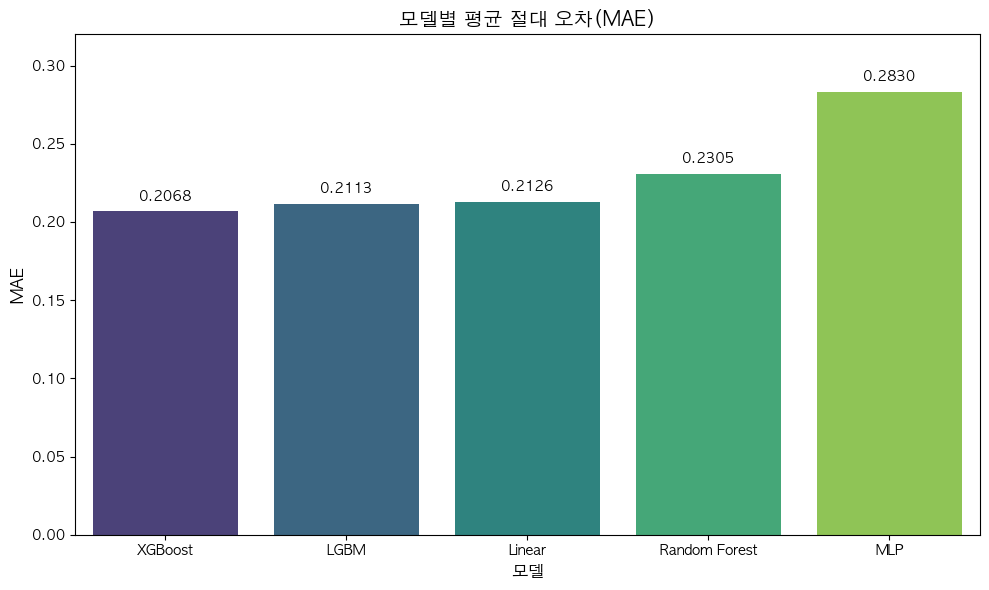

In [138]:
# Î™®Îç∏Î≥Ñ MAE Í∞í
mae_scores = {
    'XGBoost': 0.2068,
    'LGBM': 0.2113,
    'Linear': 0.2126,
    'Random Forest': 0.2305,
    'MLP': 0.2830
}

# ÏãúÍ∞ÅÌôîÏö© Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ÄÌôò
import pandas as pd
mae_df = pd.DataFrame(list(mae_scores.items()), columns=['Î™®Îç∏', 'MAE'])

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
sns.barplot(data=mae_df, x='Î™®Îç∏', y='MAE', palette='viridis')

# Í∞í ÌëúÏãú
for index, value in enumerate(mae_df['MAE']):
    plt.text(index, value + 0.005, f'{value:.4f}', ha='center', va='bottom')

plt.title('Î™®Îç∏Î≥Ñ ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®(MAE)', fontsize=14)
plt.xlabel('Î™®Îç∏', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.ylim(0, 0.32)
plt.tight_layout()
plt.show()